In [129]:
from math import pi, sqrt, tanh
import kwant
from matplotlib import pyplot
import numpy as np
from functools import partial
%matplotlib inline

# Define the graphene lattice
a = 1.
graphene = kwant.lattice.general([(a * sqrt(3) / 2., -0.5), (a * sqrt(3.) / 2., 0.5)], [(0,0), (a * 0.5 / sqrt(3.), a / 2)] )

l = 5.0
ratio = 0.8660254037844387
lx = l * ratio
ly = l
m = sin_30 / cos_30

def make_system(r=10, w=2.0, pot=0.1):
    
    #### Define the scattering region. ####
    # circular scattering region
    def hexagon(pos):
        x, y = pos
        x += 1
        y += 1
        return -lx <= x <= lx and -l <= x * m + y <= l and -l <= -x * m  + y  <= l

    def rot(vec, theta):
        rot_mat = np.array([ [np.cos(-theta), -np.sin(-theta)], [np.sin(-theta), np.cos(-theta)] ])
        return rot_mat.dot(vec)

    def rectangle(coord, angle=0., xcoords=None, ycoords=None, shift=[0., 0.]):
#         xshift = xcoords[0] + 0.5 * (xcoords[1] - xcoords[0])
#         yshift = ycoords[0] + 0.5 * (ycoords[1] - ycoords[0])
        x, y = coord
        new_val = rotation(-angle).dot((x, y))
        return xcoords[0] <= new_val[0] - shift[0] < xcoords[1] and ycoords[0] <= new_val[1] - shift[1] < ycoords[1]
    
    
    syst = kwant.Builder()
#     shape = lambda pos: hexagon(pos) + rectangle(pos, xcoords=[-lx * 2.0, -lx], ycoords=[-l*0.5, l*0.5]) + rectangle(pos, shift=[-lx / 2, -l], angle=-np.pi/6, xcoords=[0, l], ycoords=[-l / 2 , l / 2])
    shape = lambda pos:  hexagon(pos) + rectangle(pos, xcoords=[-2*l, -l], ycoords=[-l / 2, l / 2]) 


    syst[graphene.shape(hexagon , (0, 0))] = 4. * 2.7

    syst[graphene.neighbors()] =  -2.7
    syst.eradicate_dangling()
#     for key, val in syst.site_value_pairs():
#         print(key.pos)
#     sym0 = kwant.TranslationalSymmetry(graphene.vec((1,-10)))
    
#     lead0 = kwant.Builder(sym0)
#     lead0[graphene.shape(lambda pos: -20 < -m * pos[0] + pos[1] < 20 , (-l, -l))] = 4. * 2.7
#     lead0[graphene.neighbors()] = -2.7
#     lead0.eradicate_dangling()
#     for key, val in syst.site_value_pairs():
#         try:
    print(graphene.vec((-1,0)))
    sym1 = kwant.TranslationalSymmetry(rot(graphene.vec((-1,0)), -pi/3))
    lead1 = kwant.Builder(sym1)
    lead1[graphene.shape(lambda pos: -2*l < pos[1] < 2*l, (-lx,0))] = 4. * 2.7
    lead1[graphene.neighbors()] = -2.7
    syst.attach_lead(lead1)
#         except:
# #             print('tried:', key.pos)
#             pass
#     syst.attach_lead(lead0)
    return syst


def compute_evs(syst):
    # Compute some eigenvalues of the closed system
    sparse_mat = syst.hamiltonian_submatrix(sparse=True)

    evs = sla.eigs(sparse_mat, 2)[0]
    print(evs.real)


def plot_conductance(syst, energies):
    # Compute transmission as a function of energy
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(0, 1))

    pyplot.figure()
    pyplot.plot(energies, data)
    pyplot.xlabel("energy [t]")
    pyplot.ylabel("conductance [2e^2/h]")
    pyplot.show()


def plot_bandstructure(flead, momenta):
    bands = kwant.physics.Bands(flead)
    energies = [bands(k) for k in momenta]

    pyplot.figure()
    pyplot.plot(momenta, energies)
    pyplot.xlabel("momentum [(lattice constant)^-1]")
    pyplot.ylabel("energy [t]")
    pyplot.show()


pot = 0.1
syst = make_system(pot=pot)

# To highlight the two sublattices of graphene, we plot one with
# a filled, and the other one with an open circle:
def family_colors(site):
    return 0 if site.family == a else 1

# Then, plot the system with leads.
kwant.plot(syst, site_lw=0.1, lead_site_lw=0, colorbar=False, show=False)
pyplot.axis('equal')
pyplot.grid(True)
pyplot.show()

# Finalize the system.
syst = syst.finalized()

[-0.8660254037844386 0.5]


ValueError: All sites of this builder have been deleted because an exception
occurred during the execution of fill():
Builder does not interrupt the lead, this lead cannot be attached.

Total number of states: 2434.8269018133333


Text(0.5,0,'Density of states [Arbitrary units]')

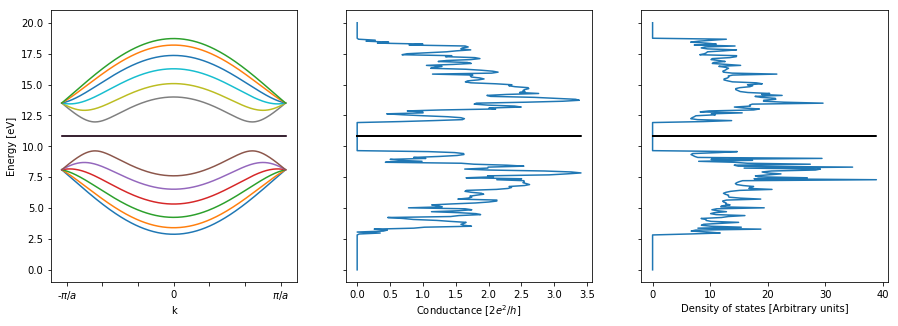

In [168]:
def conductance(syst, energies):
    data = []
    for energy in energies:
        smatrix = kwant.smatrix(syst, energy)
        data.append(smatrix.transmission(0, 1))
    return data
    

density = kwant.operator.Density(syst)

energies, doss = [], []
for e in np.linspace(0.0, 20.0, 256):
    try:
#         wf = kwant.wave_function(syst, energy=e)(0)
#         dos = density(wf[0])
        dos = kwant.ldos(syst, e)
        energies.append(e)
        doss.append(np.sum(dos))
        
#         pyplot.plot(np.absolute(wf))
#         pyplot.show()
    except:
        pass

e = np.linspace(0,20,256)
cond = conductance(syst, energies=e)
fig, axes = pyplot.subplots(1,3, figsize=(15,5), sharey='row')

kwant.plotter.bands(syst.leads[0], momenta=np.linspace(-np.pi,  np.pi, 256), show=False, ax=axes[0])
axes[1].plot(cond, e)
axes[2].plot(doss, energies)

e_fermi = np.ones(256) * 4. * 2.7
axes[0].plot(np.linspace(-np.pi,  np.pi, 256), e_fermi, color='k')
axes[1].plot(cond, e_fermi, color='k')
axes[2].plot(doss, np.ones_like(energies) * 4.0 * 2.7, color='k')

print('Total number of states:', np.sum(doss))

axes[0].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[1].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[2].set_ylim((np.min(energies) -1, np.max(energies) + 1))
axes[0].set_xlabel('k')
axes[0].set_ylabel('Energy [eV]')
pyplot.sca(axes[0])
pyplot.xticks(range(-3,4), ['-$\pi / a$', '', '', 0, '', '', '$\pi / a$'])

axes[1].set_xlabel('Conductance [$2e^2 / h$]')
axes[2].set_xlabel('Density of states [Arbitrary units]')

Text(0,0.5,'Current [2e / h]')

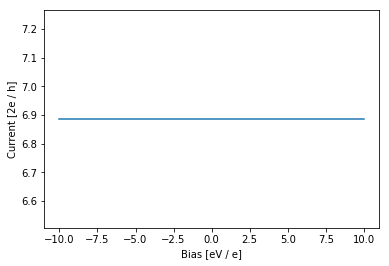

In [464]:
kB_T = 2.7 / 100.
def fermi(E, mu):
    return 1. / (np.exp((E - mu) / (100*kB_T)) + 1.)

vec_fermi = np.vectorize(fermi)

# pyplot.plot(e, vec_fermi(e, 0.1) - vec_fermi(e, -0.1))
# e = np.linspace(-10, 10, 256)
bias = np.linspace(-10.0, 10.0, 256)
V, I = [], []
for i, val in enumerate(bias):
#     mu_left = val / 2.0 + 2.7 
#     mu_right = -val / 2.0 + 2.7
    diff = vec_fermi(e, mu_left) - vec_fermi(e, mu_right)
    current = (e[1] - e[0]) * np.sum(cond * diff) 
    I.append(current)
    
pyplot.plot(bias, I)
pyplot.xlabel('Bias [eV / e]')
pyplot.ylabel('Current [2e / h]')

# This is a title

$$ \frac{\hbar^2}{2m} $$